In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
from collections import Counter

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.class_weight import compute_class_weight

In [11]:
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 15
FINE_TUNE_EPOCHS = 8

In [12]:
train_dir = r"C:\Users\Hello\Downloads\dataset\train"
test_dir = r"C:\Users\Hello\Downloads\dataset\test"

In [13]:
classes = sorted(os.listdir(train_dir))
print("Classes found:", classes)
num_classes = len(classes)

Classes found: ['freshapples', 'freshbanana', 'freshoranges', 'rottenapples', 'rottenbanana', 'rottenoranges']


In [14]:
class_counts = {}
total_train = 0

for c in classes:
    train_count = len(os.listdir(os.path.join(train_dir, c)))
    test_count = len(os.listdir(os.path.join(test_dir, c))) if os.path.exists(os.path.join(test_dir, c)) else 0
    class_counts[c] = {'train': train_count, 'test': test_count}
    total_train += train_count
    print(f"{c}: Train={train_count}, Test={test_count}")

print(f"\nTotal training samples: {total_train}")

freshapples: Train=1693, Test=395
freshbanana: Train=1581, Test=381
freshoranges: Train=1466, Test=388
rottenapples: Train=2342, Test=601
rottenbanana: Train=2224, Test=530
rottenoranges: Train=1595, Test=403

Total training samples: 10901


In [15]:
train_counts = [class_counts[c]['train'] for c in classes]
max_count = max(train_counts)
min_count = min(train_counts)
imbalance_ratio = max_count / min_count

print(f"Class imbalance ratio: {imbalance_ratio:.2f} (1.0 is perfect balance)")
if imbalance_ratio > 3.0:
    print("⚠️  WARNING: Significant class imbalance detected!")
    print("   This could cause the model to favor the majority class.")
    print("   The improved code will handle this with class weights.")

Class imbalance ratio: 1.60 (1.0 is perfect balance)


In [16]:
n_classes = len(classes)
n_rows = 2
n_cols = max(3, (n_classes + 1) // 2)

plt.figure(figsize=(15, 8))

<Figure size 1500x800 with 0 Axes>

<Figure size 1500x800 with 0 Axes>

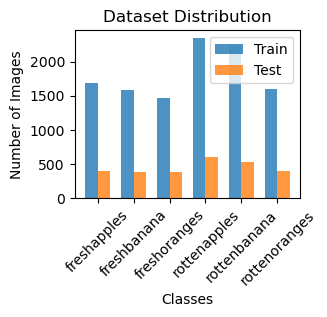

In [17]:
plt.subplot(2, 2, 1)
train_counts = [class_counts[c]['train'] for c in classes]
test_counts = [class_counts[c]['test'] for c in classes]

x = np.arange(len(classes))
width = 0.35

plt.bar(x - width/2, train_counts, width, label='Train', alpha=0.8)
plt.bar(x + width/2, test_counts, width, label='Test', alpha=0.8)
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Dataset Distribution')
plt.xticks(x, classes, rotation=45)
plt.legend()

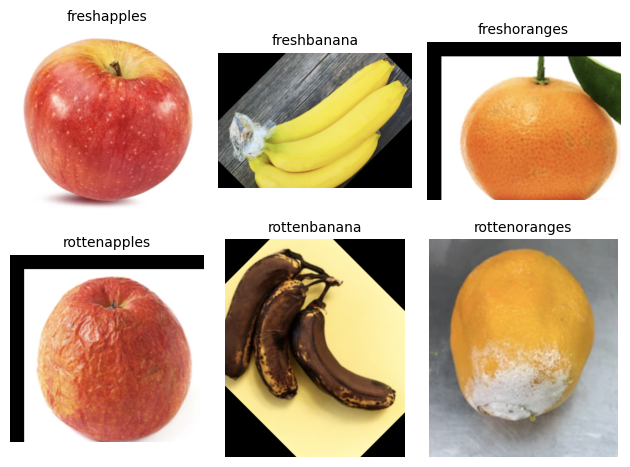

In [18]:
for i, c in enumerate(classes):
    if i >= 6:
        break
    
    class_path = os.path.join(train_dir, c)
    if os.path.exists(class_path) and os.listdir(class_path):
        img_path = os.path.join(class_path, random.choice(os.listdir(class_path)))
        try:
            img = plt.imread(img_path)
            plt.subplot(2, 3, i+1)
            plt.imshow(img)
            plt.title(c, fontsize=10)
            plt.axis("off")
        except:
            print(f"Could not load image from {c}")

plt.tight_layout()
plt.show()

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.3,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest',
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")
print("Class indices:", train_generator.class_indices)

Found 8723 images belonging to 6 classes.
Found 2178 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.
Training samples: 8723
Validation samples: 2178
Test samples: 2698
Class indices: {'freshapples': 0, 'freshbanana': 1, 'freshoranges': 2, 'rottenapples': 3, 'rottenbanana': 4, 'rottenoranges': 5}


In [21]:
y_train = train_generator.classes
unique_classes = np.unique(y_train)
class_weights = compute_class_weight('balanced', classes=unique_classes, y=y_train)
class_weight_dict = dict(zip(unique_classes, class_weights))

print("Class weights (to handle imbalance):")
for i, (class_name, weight) in enumerate(zip(classes, class_weights)):
    print(f"  {class_name}: {weight:.3f}")

Class weights (to handle imbalance):
  freshapples: 1.073
  freshbanana: 1.149
  freshoranges: 1.239
  rottenapples: 0.776
  rottenbanana: 0.817
  rottenoranges: 1.139


In [22]:
def create_model():

    base_model = MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
    )

    base_model.trainable = False

    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    
    return model, base_model

model, base_model = create_model()

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("Model created successfully!")
model.summary()

Model created successfully!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [23]:
checkpoint = ModelCheckpoint(
    'best_fruit_model.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

In [24]:
history_1 = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

C:\Users\Hello\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4414 - loss: 1.5016  
Epoch 1: val_accuracy improved from None to 0.90358, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 481s 2s/step - accuracy: 0.5993 - loss: 1.0617 - val_accuracy: 0.9036 - val_loss: 0.3314 - learning_rate: 1.0000e-04
Epoch 2/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8064 - loss: 0.5496  
Epoch 2: val_accuracy improved from 0.90358 to 0.93021, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - accuracy: 0.8173 - loss: 0.5103 - val_accuracy: 0.9302 - val_loss: 0.2152 - learning_rate: 1.0000e-04
Epoch 3/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8687 - loss: 0.3885  
Epoch 3: val_accuracy improved from 0.93021 to 0.94215, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 394s 1s/step - accuracy: 0.8668 - loss: 0.3838 - val_accuracy: 0.9421 - val_loss: 0.1796 - learning_rate: 1.0000e-04
Epoch 4/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8753 - loss: 0.3590  
Epoch 4: val_accuracy improved from 0.94215 to 0.95271, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 500s 2s/step - accuracy: 0.8819 - loss: 0.3315 - val_accuracy: 0.9527 - val_loss: 0.1571 - learning_rate: 1.0000e-04
Epoch 5/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8942 - loss: 0.2916  
Epoch 5: val_accuracy improved from 0.95271 to 0.95822, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 408s 1s/step - accuracy: 0.8985 - loss: 0.2813 - val_accuracy: 0.9582 - val_loss: 0.1306 - learning_rate: 1.0000e-04
Epoch 6/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9024 - loss: 0.2811  
Epoch 6: val_accuracy improved from 0.95822 to 0.96281, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 395s 1s/step - accuracy: 0.9055 - loss: 0.2737 - val_accuracy: 0.9628 - val_loss: 0.1147 - learning_rate: 1.0000e-04
Epoch 7/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9110 - loss: 0.2519  
Epoch 7: val_accuracy did not improve from 0.96281
273/273 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9128 - loss: 0.2473 - val_accuracy: 0.9628 - val_loss: 0.1122 - learning_rate: 1.0000e-04
Epoch 8/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9109 - loss: 0.2415  
Epoch 8: val_accuracy did not improve from 0.96281
273/273 ━━━━━━━━━━━━━━━━━━━━ 393s 1s/step - accuracy: 0.9172 - loss: 0.2293 - val_accuracy: 0.9619 - val_loss: 0.1062 - learning_rate: 1.0000e-04
Epoch 9/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9142 - loss: 0.2310  
Epoch 9: val_accuracy improved from 0.96281 to 0.96602, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 401s 1s/step - accuracy: 0.9175 - loss: 0.2287 - val_accuracy: 0.9660 - val_loss: 0.1023 - learning_rate: 1.0000e-04
Epoch 10/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9152 - loss: 0.2234  
Epoch 10: val_accuracy improved from 0.96602 to 0.96786, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9211 - loss: 0.2137 - val_accuracy: 0.9679 - val_loss: 0.0963 - learning_rate: 1.0000e-04
Epoch 11/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9249 - loss: 0.2103  
Epoch 11: val_accuracy did not improve from 0.96786
273/273 ━━━━━━━━━━━━━━━━━━━━ 399s 1s/step - accuracy: 0.9250 - loss: 0.2101 - val_accuracy: 0.9665 - val_loss: 0.0978 - learning_rate: 1.0000e-04
Epoch 12/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9288 - loss: 0.2053  
Epoch 12: val_accuracy improved from 0.96786 to 0.96924, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 405s 1s/step - accuracy: 0.9259 - loss: 0.2081 - val_accuracy: 0.9692 - val_loss: 0.0937 - learning_rate: 1.0000e-04
Epoch 13/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9286 - loss: 0.1949  
Epoch 13: val_accuracy did not improve from 0.96924
273/273 ━━━━━━━━━━━━━━━━━━━━ 403s 1s/step - accuracy: 0.9296 - loss: 0.1925 - val_accuracy: 0.9679 - val_loss: 0.0973 - learning_rate: 1.0000e-04
Epoch 14/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9327 - loss: 0.1858  
Epoch 14: val_accuracy did not improve from 0.96924
273/273 ━━━━━━━━━━━━━━━━━━━━ 409s 1s/step - accuracy: 0.9348 - loss: 0.1830 - val_accuracy: 0.9688 - val_loss: 0.0878 - learning_rate: 1.0000e-04
Epoch 15/15
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9277 - loss: 0.1944  
Epoch 15: val_accuracy improved from 0.96924 to 0.97475, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 434s 2s/step - accuracy: 0.9344 - loss: 0.1793 - val_accuracy: 0.9747 - val_loss: 0.0865 - learning_rate: 1.0000e-04
Restoring model weights from the end of the best epoch: 15.


In [25]:
base_model.trainable = True

fine_tune_at = len(base_model.layers) // 2  

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(f"Fine-tuning from layer {fine_tune_at} onwards...")

total_epochs = EPOCHS + FINE_TUNE_EPOCHS
history_2 = model.fit(
    train_generator,
    epochs=total_epochs,
    initial_epoch=history_1.epoch[-1],
    validation_data=validation_generator,
    class_weight=class_weight_dict,
    callbacks=[checkpoint, early_stopping, reduce_lr],
    verbose=1
)

Fine-tuning from layer 77 onwards...
Epoch 15/23
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7167 - loss: 0.9692  
Epoch 15: val_accuracy did not improve from 0.97475
273/273 ━━━━━━━━━━━━━━━━━━━━ 620s 2s/step - accuracy: 0.8157 - loss: 0.5799 - val_accuracy: 0.9385 - val_loss: 0.1735 - learning_rate: 1.0000e-05
Epoch 16/23
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.8969 - loss: 0.2842  
Epoch 16: val_accuracy did not improve from 0.97475
273/273 ━━━━━━━━━━━━━━━━━━━━ 564s 2s/step - accuracy: 0.9105 - loss: 0.2551 - val_accuracy: 0.9440 - val_loss: 0.1692 - learning_rate: 1.0000e-05
Epoch 17/23
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9290 - loss: 0.2005  
Epoch 17: val_accuracy did not improve from 0.97475

Epoch 17: ReduceLROnPlateau reducing learning rate to 1.9999999494757505e-06.
273/273 ━━━━━━━━━━━━━━━━━━━━ 574s 2s/step - accuracy: 0.9310 - loss: 0.1974 - val_accuracy: 0.9518 - val_loss: 0.1381 - learning_rate: 1.0000e-05
Epoch 18/23
273/273 ━━━━━━

273/273 ━━━━━━━━━━━━━━━━━━━━ 607s 2s/step - accuracy: 0.9465 - loss: 0.1501 - val_accuracy: 0.9770 - val_loss: 0.0659 - learning_rate: 2.0000e-06
Epoch 22/23
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9389 - loss: 0.1683  
Epoch 22: val_accuracy improved from 0.97704 to 0.98118, saving model to best_fruit_model.h5


273/273 ━━━━━━━━━━━━━━━━━━━━ 589s 2s/step - accuracy: 0.9468 - loss: 0.1528 - val_accuracy: 0.9812 - val_loss: 0.0574 - learning_rate: 2.0000e-06
Epoch 23/23
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9541 - loss: 0.1372  
Epoch 23: val_accuracy did not improve from 0.98118
273/273 ━━━━━━━━━━━━━━━━━━━━ 594s 2s/step - accuracy: 0.9510 - loss: 0.1431 - val_accuracy: 0.9770 - val_loss: 0.0573 - learning_rate: 2.0000e-06
Restoring model weights from the end of the best epoch: 23.


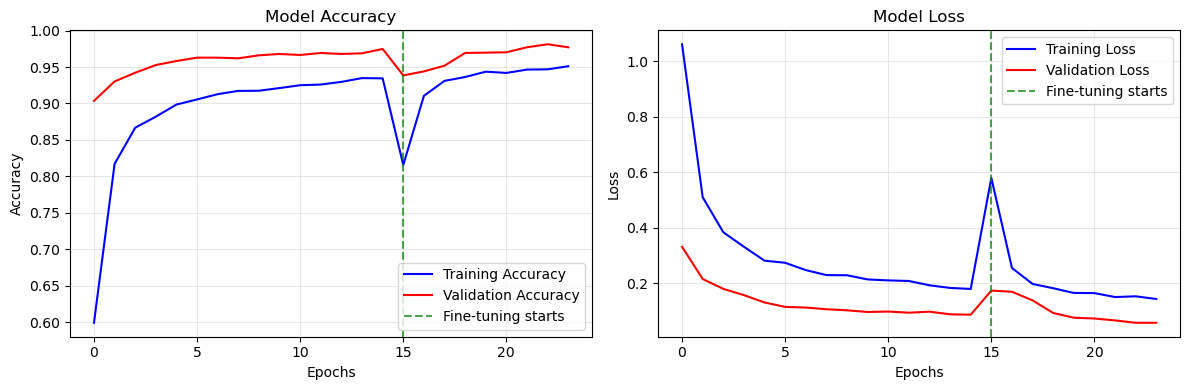

In [26]:
def plot_training_history(hist1, hist2):
    acc = hist1.history['accuracy'] + hist2.history['accuracy']
    val_acc = hist1.history['val_accuracy'] + hist2.history['val_accuracy']
    loss = hist1.history['loss'] + hist2.history['loss']
    val_loss = hist1.history['val_loss'] + hist2.history['val_loss']
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(acc, 'b-', label='Training Accuracy')
    plt.plot(val_acc, 'r-', label='Validation Accuracy')
    plt.axvline(x=len(hist1.history['accuracy']), color='green', 
                linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.subplot(1, 2, 2)
    plt.plot(loss, 'b-', label='Training Loss')
    plt.plot(val_loss, 'r-', label='Validation Loss')
    plt.axvline(x=len(hist1.history['loss']), color='green', 
                linestyle='--', alpha=0.7, label='Fine-tuning starts')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_1, history_2)

In [27]:
model.load_weights('best_fruit_model.h5')

test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nFinal Test Results:")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

test_generator.reset()
y_pred_proba = model.predict(test_generator, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)
y_true = test_generator.classes

85/85 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9811 - loss: 0.0524   

Final Test Results:
Test Loss: 0.0524
Test Accuracy: 98.11%
85/85 ━━━━━━━━━━━━━━━━━━━━ 67s 773ms/step


In [28]:
report = classification_report(y_true, y_pred, target_names=classes, digits=4)
print(report)

pred_counts = Counter(y_pred)

               precision    recall  f1-score   support

  freshapples     0.9311    0.9924    0.9608       395
  freshbanana     0.9974    1.0000    0.9987       381
 freshoranges     0.9747    0.9923    0.9834       388
 rottenapples     0.9879    0.9517    0.9695       601
 rottenbanana     0.9981    0.9981    0.9981       530
rottenoranges     0.9923    0.9628    0.9773       403

     accuracy                         0.9811      2698
    macro avg     0.9803    0.9829    0.9813      2698
 weighted avg     0.9817    0.9811    0.9811      2698



freshapples: 421 predictions (15.6%)
freshbanana: 382 predictions (14.2%)
freshoranges: 395 predictions (14.6%)
rottenapples: 579 predictions (21.5%)
rottenbanana: 530 predictions (19.6%)
rottenoranges: 391 predictions (14.5%)


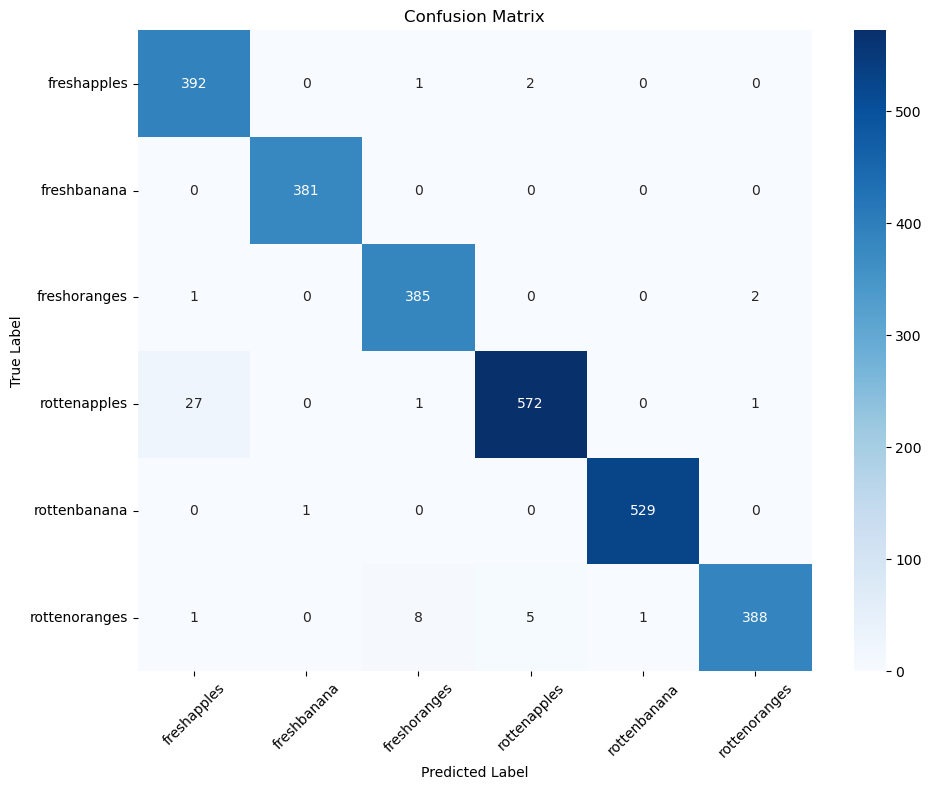

In [29]:
for i, class_name in enumerate(classes):
    count = pred_counts.get(i, 0)
    percentage = (count / len(y_pred)) * 100
    print(f"{class_name}: {count} predictions ({percentage:.1f}%)")

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [30]:
misclassified_indices = np.where(y_pred != y_true)[0]
print(f"Total misclassified: {len(misclassified_indices)} out of {len(y_true)}")

if len(misclassified_indices) > 0:
    print("\nMost common misclassifications:")
    misclass_pairs = [(classes[y_true[i]], classes[y_pred[i]]) for i in misclassified_indices]
    misclass_counts = Counter(misclass_pairs)
    
    for (true_class, pred_class), count in misclass_counts.most_common(5):
        print(f"  {true_class} → {pred_class}: {count} times")

Total misclassified: 51 out of 2698

Most common misclassifications:
  rottenapples → freshapples: 27 times
  rottenoranges → freshoranges: 8 times
  rottenoranges → rottenapples: 5 times
  freshapples → rottenapples: 2 times
  freshoranges → rottenoranges: 2 times


In [32]:
model.save('fruit_freshness_model.h5')
model.export('fruit_freshness_model_saved')
print("✅ Model saved successfully!")

print("\n" + "="*50)
print("🎉 TRAINING COMPLETE!")
print("="*50)
print(f"✅ Final test accuracy: {test_accuracy*100:.2f}%")
print("✅ Model saved as 'fruit_freshness_model.h5'")
print("✅ Ready for Streamlit deployment!")

if test_accuracy > 0.8:
    print("🌟 Great job! Your model achieved good accuracy.")
elif test_accuracy > 0.6:
    print("📈 Decent performance. Consider more data or tuning.")
else:
    print("⚠️  Low accuracy. Check your data quality and class balance.")

print("\nNext steps:")
print("1. Run the Streamlit app: streamlit run streamlit_app.py")
print("2. Test with various fruit images")
print("3. Deploy to Streamlit Cloud")

INFO:tensorflow:Assets written to: fruit_freshness_model_saved\assets


INFO:tensorflow:Assets written to: fruit_freshness_model_saved\assets


Saved artifact at 'fruit_freshness_model_saved'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2032867176528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867172880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867176912: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867165392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867172304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867165584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867171920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867168848: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867172688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867172496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2032867173264: Tens